## <font color='blue'> EconophysiX Internship - Felipe Moret \& Michele Vodret - Microfounding Propagator Models </font>

## <font color='red'> Studiyng A Rational Noise Trader with Simplified Utility Function (First Part of Background Notes) </font>

In [148]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
from scipy import linalg
from mpmath import *
from numba import njit

def delta(i):
    if i == 0:
        return 1
    else:
        return 0
    
def delta_vector(vec):
    vec[0] = 1
    vec[1:] = 0
    return vec

## Auxilliary functions for common ACFs

**Markovian Process ACF**

In [4]:
def return_Markovian_ACF(C_0, tau, T):
    ACF = np.zeros((T,T))
    alpha = np.exp(-1/tau)
    for i in range(0,T):
        for j in range(0,T):
            ACF[i,j] = C_0*alpha**np.abs(i-j)
    return ACF

## Coding the forecast matrix

In [5]:
#@njit
def optimized_matrix_inverse(matrix):
    return np.linalg.inv(matrix)

In [6]:
def Mforecast(tipo, process, param, t0, T, C_fixed):

        tau_mu = param[0]
        tau_NT = param[1]
        if tipo == "mark":
            if process == "MU":
                alpha_appo = np.exp(-1/param[0])
                C_appo = np.fromfunction(lambda i,j : alpha_appo**np.abs(i-j), (T,T), dtype = float)
                flag = 0
            if process == "NT":
                alpha_appo = np.exp(-1/param[1])
                C_appo = np.fromfunction(lambda i,j : alpha_appo**np.abs(i-j), (T,T), dtype = float)
                flag = 0
        if tipo == "osc":
            if process == "MU":
                alpha_mu = np.exp(-1/param[0])
                tau1_mu = param[1]
                C_appo = np.fromfunction(lambda i,j : alpha_mu**np.abs(i-j)*np.sin((i-j)/tau1_mu+np.pi/2), (T,T), dtype = float)
                flag = 0
            if process == "NT":
                alpha_NT = np.exp(-1/param[2])
                tau1_NT = param[3]
                C_appo = np.fromfunction(lambda i,j : alpha_NT**np.abs(i-j)*np.sin((i-j)/(tau1_NT)+np.pi/2), (T,T), dtype = float)
                flag = 0
                     
        if tipo == "id":
            C_appo = np.identity(T)
            flag = 0
        
        if tipo == "pl":
            if process == "MU":
                tau = param[0]
                gamma = param[1]
                C_appo = (np.fromfunction(lambda i, j: np.power( 1+np.absolute(i-j)/tau,-gamma), (T,T), dtype=float))
                flag = 0
            if process == "NT":
                tau = param[2]
                gamma = param[3]
                C_appo = (np.fromfunction(lambda i, j: np.power( 1+np.absolute(i-j)/tau,-gamma), (T,T), dtype=float))
                flag = 0
        
        if tipo == "fixed":
                C_appo = C_fixed
                flag = 1
            
        g = np.zeros((T-t0,t0))
        for J in range (t0+1,T+1):
            
            # In the case of a fixed ACF given, this part of the code augments the correlation matrix at each 
            # iteration, in view of evaluating the forecasts
            if(flag):
                C_last = C_appo
                C_appo = np.zeros((J,J))
                J_last = C_last.shape[0]
                for i in range (0,J_last):
                    for j in range(0,J_last):
                        C_appo[i,j] = C_last[i,j]
                if(C_appo.shape[0] > C_last.shape[0]):
                    C_appo[0,C_appo.shape[0]-1] = 0
                    C_appo[C_appo.shape[0]-1,0] = 0
                    for row in range(1,C_appo.shape[0]):
                        C_appo[row,C_appo.shape[0]-1] = C_appo[row-1,C_appo.shape[0]-2]
                    C_appo[C_appo.shape[0]-1,1:] = C_appo[1:C_appo.shape[0],C_appo.shape[0]-1]
                        
                
            C = C_appo[:J,:J]
            #print(C)
            #print('\n\n')
            inv_C = optimized_matrix_inverse(C)
            inv_C[np.abs(inv_C) < pow(10,-10)] = 0 ###added line for optimization
            inv_C_int = inv_C[t0:J-1,t0:J-1]
            inv_inv_C_int = optimized_matrix_inverse(inv_C_int)
            inv_inv_C_int[np.abs(inv_inv_C_int) < pow(10,-10)] = 0 ###added line for optimization
            delta_inv_C = +inv_C[:,t0:J-1].dot(inv_inv_C_int).dot(inv_C[t0:J-1,:])
            delta_inv_C[np.abs(delta_inv_C) < pow(10,-10)] = 0 ##added line for optimization
            matrix = (inv_C[J-1,J-1]-delta_inv_C[J-1,J-1])**(-1)*(inv_C-delta_inv_C)
            g[J-t0-1,:t0] = matrix[J-1,:t0]
        return g

## Coding $\mathsf{G}$ and $\mathsf{G_{/t,t-1}}$

In [7]:
def return_G(G_0_seed, alpha_G, T):
    G_0_seed = G_0_seed
    alpha_G = alpha_G
    G_seed = G_0_seed*np.fromfunction(lambda i,j : alpha_G**np.abs(j-i)*np.heaviside(j-i,1), (T,T),dtype = np.float)
    return G_seed

In [8]:
def return_G_futpast(G):
    
    T = G.shape[0]
    
    # G_{/T,T-1}
    G_futpast = np.zeros((T,T))
    
    for i in range(0,T):
        dummy = i + 1
        for j in range(0,T-dummy):
            k = j + dummy
            G_futpast[i][j] = G[0,k]

    return G_futpast

## Coding the Noise Trader's Kernels

In [9]:
#This function returns the kernels respective to the Noise Trader's trading schedule
#alpha > 0

def NTKernels(alpha, G):
    
    T = G.shape[0]
    
    G_sym = G + G.T
    
    #This can represent e_{T-1} and also e_{/T} 
    e_T = np.zeros((T,1))
    e_T[0,0] = 1
    
    ones_vec = np.ones((T,1))
    
    L = np.fromfunction(lambda i, j: np.vectorize(delta)(i-j+1), (T,T), dtype = np.float)

    M = -alpha*G_sym - 2*np.matmul(e_T,e_T.T)
    M_inv = np.linalg.inv(M)
    
    # G_{/T,T-1}
    G_futpast = return_G_futpast(G)

    #COMPUTING J
    #J is the noise trader's kernel relative to the past excess demand
    j_t = np.matmul(e_T.T,alpha*np.matmul(M_inv,G_futpast) + 2*np.matmul(M_inv,np.matmul(e_T,ones_vec.T)))
    j_t = j_t.dot(L)
    J = np.zeros((T,T))
    
    for i in range (0,T):
        J[i,i:T] = j_t[0,:T-i]

    #COMPUTING J_IT
    #J_IT is the noise trader's kernel relative to the past informed trader's demand 
    
    #F_IT = Mforecast("mark","MU",[1,1],T,2T)
    #F_IT[np.abs(F_IT) < pow(10,-15)] = 0
    
    #We are using the hypothesis that the noise trader does not know how to forecast the IT's trades
    F_IT = np.zeros((T,T))
    
    #J_IT is the noise trader's kernel relative to the past informed trader's demand 
    j_IT = np.matmul(e_T.T,alpha*np.matmul(M_inv,np.matmul(G.T,F_IT)) - 2*np.matmul(M_inv,np.matmul(e_T,ones_vec.T)))
    j_IT = j_IT.dot(L)
    J_IT = np.zeros((T,T))
    
    for i in range (0,T):
        J_IT[i,i:T] = j_IT[0,:T-i]
        
    #COMPUTING J_TGT
    #J_TGT is the noise trader's kernel relative to the past target portolio's demand
    j_TGT = np.matmul(e_T.T,-2*np.matmul(M_inv,np.matmul(e_T, ones_vec.T)))
    J_TGT = np.zeros((T,T))
    
    for i in range (0,T):
        J_TGT[i,i:T] = j_TGT[0,:T-i]
    
    return J,J_IT,J_TGT

## Coding the Informed Trader's Kernels

In [10]:
#This function returns the kernels respective to the Informed Trader's trading schedule
#ACF_NT is the auto-correlation matrix of the noise trader's trades

def ITKernels(G, ACF_NT, F_MU, is_rational, F_NT_irrational):
    
    T = G.shape[0]
    
    G_sym = G + G.T
    G_sym_inv = np.linalg.inv(G_sym)
    
    #This represents e_{/T} 
    e_T = np.zeros((T,1))
    e_T[0,0] = 1
    
    L = np.fromfunction(lambda i, j: np.vectorize(delta)(i-j+1), (T,T), dtype = np.float)

    ones_vec = np.ones((T,1))
    
    # G_{/T,T-1}
    G_futpast = return_G_futpast(G)
        
    #COMPUTING K
    #K is the informed trader's kernel relative to the past excess demand
    k_t = -1*np.matmul(e_T.T,np.matmul(G_sym_inv,G_futpast))
    k_t = k_t.dot(L)
    K = np.zeros((T,T))
        
    for i in range (0,T):
        K[i,i:T] = k_t[0,:T-i]
        
   
    #COMPUTING K_NT
    #K_NT is the informed trader's kernel relative to the past noise trader's demand
    if is_rational == True:
        F_NT = -np.flip(Mforecast('fixed', '_', [_,_], T, 2*T,ACF_NT),1)
    else:
        F_NT = F_NT_irrational


    k_NT = -1*np.matmul(e_T.T,np.matmul(G_sym_inv,np.matmul(G.T,F_NT)))
    k_NT = k_NT.dot(L)
    
    K_NT = np.zeros((T,T))
    
    for i in range (0,T):
        K_NT[i,i:T] = k_NT[0,:T-i]
    
  
    #COMPUTING K_MU
    #K_MU is the informed trader's kernel relative to the past dividends realizations 
    
    U = np.ones((T,T))
    U = np.triu(U)
    
    k_MU = np.matmul(e_T.T,np.matmul(G_sym_inv,np.matmul(U,F_MU)))
    k_MU = k_MU.dot(L)
        
    K_MU = np.zeros((T,T))
    
    for i in range (0,T):
        K_MU[i,i:T] = k_MU[0,:T-i]
        
    return K, K_NT, K_MU

## Coding the  $\mathsf{D}s$ matrices

In [11]:
def return_Ds(G, alpha, ACF_NT, F_MU):
    
    T = G.shape[0]
    
    J, J_IT, J_TGT = NTKernels(alpha, G)
    
    K, K_NT, K_MU = ITKernels(G, ACF_NT, F_MU, True, _) 
        
    I = np.identity(T)
    
    L = np.fromfunction(lambda i, j: np.vectorize(delta)(i-j+1), (T,T), dtype = np.float)

    aux_1 = np.linalg.inv(I - K)
    aux_2 = np.linalg.inv(I - J)
        
    X = I - J - np.matmul(J + J_IT, np.matmul(aux_1, K + K_NT))
    
    Y = I - K - np.matmul(K + K_NT, np.matmul(aux_2, J + J_IT))
    
    X_inv = np.linalg.inv(X)
    Y_inv = np.linalg.inv(Y)
        
    #Noise Trader's Ds
    D_MU_NT = np.matmul(X_inv,np.matmul(J+J_IT, np.matmul(aux_1, K_MU)))
    
    D_TGT_NT = np.matmul(X_inv,J_TGT) 
    
    #Informed Trader's Ds
    D_MU_IT = np.matmul(Y_inv,K_MU)
    
    D_TGT_IT = np.matmul(Y_inv,np.matmul(K+K_NT,np.matmul(aux_2,J_TGT)))
    
    #Market Maker's Ds
    D_MU = D_MU_NT + D_MU_IT
    
    D_TGT = D_TGT_NT + D_TGT_IT
    
    return D_MU, D_TGT, D_MU_NT, D_TGT_NT, D_MU_IT, D_TGT_IT


## Coding the ACFs

In [12]:
def return_ACF_NT(ACF_MU, ACF_TGT, Ds):    

    D_MU_NT = Ds[2]
    D_TGT_NT = Ds[3]
    
    ACF_NT = np.matmul(D_TGT_NT, np.matmul(ACF_TGT, D_TGT_NT.T)) + np.matmul(D_MU_NT, np.matmul(ACF_MU, D_MU_NT.T))
        
    return ACF_NT

In [13]:
def return_ACF_IT(ACF_MU, ACF_TGT, Ds):
    
    D_MU_IT = Ds[4]
    D_TGT_IT = Ds[5]
    
    ACF_IT = np.matmul(D_TGT_IT, np.matmul(ACF_TGT, D_TGT_IT.T)) + np.matmul(D_MU_IT, np.matmul(ACF_MU, D_MU_IT.T))
        
    return ACF_IT

In [14]:
def return_ACF_Q(ACF_MU,ACF_TGT, Ds):
    
    D_MU = Ds[0]
    D_TGT = Ds[1]
    
    ACF_Q = np.matmul(D_TGT, np.matmul(ACF_TGT, D_TGT.T)) + np.matmul(D_MU, np.matmul(ACF_MU, D_MU.T))
        
    return ACF_Q

In [15]:
def return_ACF_P(ACF_Q, G):
        ACF_P = G.dot(ACF_Q).dot(np.transpose(G))
        return ACF_P

In [16]:
def return_ACF_P_F(ACF_MU):

    T = ACF_MU.shape[0]
    
    U = np.ones((T,T))
    U = np.triu(U)
    
    ACF_P_F = np.matmul(U, np.matmul(ACF_MU, U.T))
    
    return ACF_P_F

## Coding the Kalman Filter used by the Market Maker

In [17]:
def kalman_filter(G, ACF_MU, ACF_Q, D_MU):
    
    T = G.shape[0]
           
    ACF_Q_inv = np.linalg.inv(ACF_Q)
    aux = np.matmul(ACF_MU,D_MU.T)
        
    return np.matmul(aux, ACF_Q_inv)

## Coding the equilibrium equation - A self-consistent equation for G

In [18]:
def new_G_from_equilibrium(G,K,F_MU):
    
    T = G.shape[0]
    
    g = np.zeros((1,T))
    
    e_T = np.zeros((1,T))
    e_T[0,0] = 1
    
    F_MU_g = np.zeros((T,T))
    F_MU_g[[0],:] = e_T
    F_MU_g[1:,:] = F_MU[:T-1,:T]

    for s in range(0,T):
        sum_aux = 0
        for t_prime in range(0,T):
            for t_two_primes in range(0,T):
                sum_aux = sum_aux + F_MU_g[t_prime,t_two_primes]*K[t_two_primes,s]
        g[0,s] = sum_aux
    
    G = np.zeros((T,T))

    for i in range (0,T):
        G[i,i:T] = g[0,0:T-i] 
        
    return G        

## Numerical Solvers - Rational and Irrational Noise Traders

In [24]:
def numerical_solver_rational_noise_trader(T, T_it, G_0_seed, alpha_G, alpha, C_MU_0, tau_MU, ACF_TGT, seed_type_NT, C_NT_0, tau_NT):
    
    G = return_G(G_0_seed, alpha_G, T)
    
    ACF_MU = return_Markovian_ACF(C_MU_0, tau_MU, T)
    F_MU = -np.flip(Mforecast('mark','MU',[tau_MU,_],T,2*T,_),1)

    G_s = []
    ACFs_NT = []
    ACFs_Q = []
    ACFs_IT = []
    
    for iteration in range(0,T_it):
        
        G_s.append(G[0,:])
        
        if(iteration == 0):
            if seed_type_NT == "mark":
                ACF_NT = return_Markovian_ACF(C_NT_0, tau_NT, T)
            if seed_type_NT == "id":
                ACF_NT = np.identity(T)
   
        Ds = return_Ds(G, alpha, ACF_NT, F_MU)
        
        ACF_Q = return_ACF_Q(ACF_MU, ACF_TGT, Ds)
        
        K = kalman_filter(G, ACF_MU, ACF_Q, Ds[0])

        G = new_G_from_equilibrium(G,K,F_MU) 

        ACF_NT = return_ACF_NT(ACF_MU, ACF_TGT, Ds)
        ACF_IT = return_ACF_IT(ACF_MU, ACF_TGT, Ds)
        
        #plt.plot(np.arange(0,T), ACF_Q[0,:T])
        #plt.show()
        
        ACFs_IT.append(ACF_IT)
        ACFs_NT.append(ACF_NT)
        ACFs_Q.append(ACF_Q)
        
        
        print(f"This is iteration: {iteration + 1}\n")
        

    return G, G_s, ACFs_NT, ACFs_IT, ACFs_Q, ACF_MU

In [25]:
def numerical_solver_irrational_noise_trader(T, T_it, G_0_seed, alpha_G, C_MU_0, C_NT_0, tau_MU, tau_NT):
    
    G = return_G(G_0_seed, alpha_G, T)
    
    ACF_MU = return_Markovian_ACF(C_MU_0, tau_MU, T)
    ACF_NT = np.identity(T)
    
    F_MU = -np.flip(Mforecast('mark','MU',[tau_MU,_],T,2*T,_),1)
    F_NT = -np.flip(Mforecast('id','NT',[_,tau_NT],T,2*T,_),1)
    

    G_s = []
  
    I = np.identity(T)
    
    L = np.fromfunction(lambda i, j: np.vectorize(delta)(i-j+1), (T,T), dtype = np.float)

    for iteration in range(0,T_it):
        
        G_s.append(G[0,:])
        
        #Computing IT Kernels
        K, K_NT, K_MU = ITKernels(G,_, F_MU, False, F_NT)
        
        aux1 = np.linalg.inv(I - K)
        aux2 = I + K_NT
        
        D_MU = np.matmul(aux1,K_MU)
        
        ACF_Q = np.matmul(D_MU, np.matmul(ACF_MU,D_MU.T)) + np.matmul(aux1, np.matmul(aux2, np.matmul(ACF_NT, np.matmul(aux2.T,aux1.T))))
     
        Kalman = kalman_filter(G, ACF_MU, ACF_Q, D_MU)
                
        G = new_G_from_equilibrium(G,Kalman,F_MU)
        
        print(f"This is iteration: {iteration + 1}\n")
        
    ACF_P = return_ACF_P(ACF_Q, G) 
    ACF_P_F = return_ACF_P_F(ACF_MU)
    
    aux3 = K + K_NT
    ACF_IT = np.matmul(aux1, np.matmul(aux3, np.matmul(ACF_NT, np.matmul(aux3.T, aux1.T)))) + np.matmul(aux1,np.matmul(K_MU, np.matmul(ACF_MU, np.matmul(K_MU.T, aux1.T))))

    return G, G_s, ACF_Q, ACF_NT, ACF_MU, ACF_P, ACF_P_F, ACF_IT

## Analysis of results - Rational Noise Trader - $\alpha = 0.5$

**Iterating the self-consistent equation**

In [26]:
T = 100
T_it = 200
G_0_seed = 1
alpha_G = 0.5
alpha = 0.5
C_MU_0 = 1
tau_MU = 3

#The NT's trade are non-correlated
seed_type_NT = "id"
C_NT_0 = 1
tau_NT = 1


#Target portfolio is a white noise
ACF_TGT = np.identity(T)


G_Rational, G_s_Rational, ACFs_NT_Rational, ACFs_IT, ACFs_Q_Rational, ACF_MU_Rational = numerical_solver_rational_noise_trader(T, T_it, G_0_seed, alpha_G, alpha, C_MU_0, tau_MU, ACF_TGT, seed_type_NT, C_NT_0, tau_NT)

This is iteration: 1

This is iteration: 2

This is iteration: 3

This is iteration: 4

This is iteration: 5

This is iteration: 6

This is iteration: 7

This is iteration: 8

This is iteration: 9

This is iteration: 10

This is iteration: 11

This is iteration: 12

This is iteration: 13

This is iteration: 14

This is iteration: 15

This is iteration: 16

This is iteration: 17

This is iteration: 18

This is iteration: 19

This is iteration: 20

This is iteration: 21

This is iteration: 22

This is iteration: 23

This is iteration: 24

This is iteration: 25

This is iteration: 26

This is iteration: 27

This is iteration: 28

This is iteration: 29

This is iteration: 30

This is iteration: 31

This is iteration: 32

This is iteration: 33

This is iteration: 34

This is iteration: 35

This is iteration: 36

This is iteration: 37

This is iteration: 38

This is iteration: 39

This is iteration: 40

This is iteration: 41

This is iteration: 42

This is iteration: 43

This is iteration: 4

## Last propagator found - Rational Noise Trader

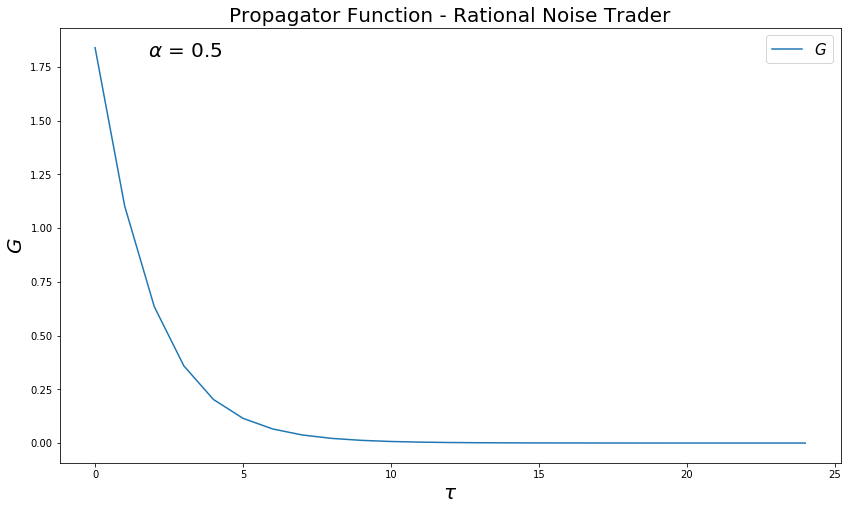

In [27]:
figure1 = plt.figure(figsize = (14,8))
plt.title("Propagator Function - Rational Noise Trader", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)
plt.plot(np.arange(0,25), G_Rational[0,:25],label = r"$G$")
plt.text(1.8,1.8,r"$\alpha$ = {}".format(alpha), fontsize = 20)
plt.legend(prop={'size': 15})
plt.show()

**Plotting the Euclidean Distance between sucessive propagators in G_s**

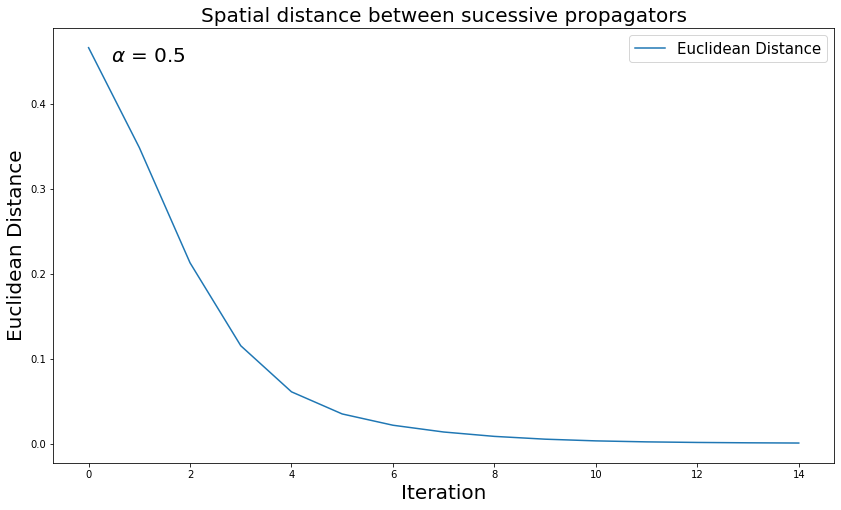

In [28]:
from scipy.spatial.distance import euclidean
figure2 = plt.figure(figsize = (14,8))
plt.title("Spatial distance between sucessive propagators", fontsize = 20)
plt.xlabel(r"Iteration", fontsize = 20)
plt.ylabel(r"Euclidean Distance", fontsize = 20)

distances = np.ones(T_it-1)

for i in range(0,T_it-1):
    distances[i] = euclidean(G_s_Rational[i],G_s_Rational[i+1])
    
plt.plot(np.arange(0,15),distances[:15], label = "Euclidean Distance")
plt.text(0.45,0.45,r"$\alpha$ = {}".format(alpha), fontsize = 20)
plt.legend(prop={'size': 15})

## Collapse between $G/G_{0}$ and $C_{\mu}/C_{\mu}^{0}$

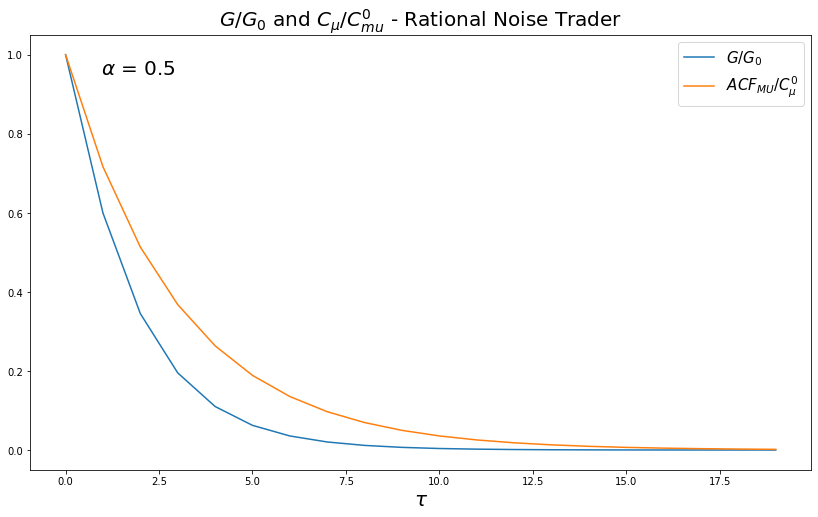

In [29]:
figure3 = plt.figure(figsize = (14,8))
plt.title(r"$G/G_{0}$ and $C_{\mu}/C_{mu}^{0}$ - Rational Noise Trader", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.plot(np.arange(0,20), G_Rational[0,:20]/G_Rational[0,0], label = r"$G/G_{0}$")
plt.plot(np.arange(0,20), ACF_MU_Rational[0,:20]/C_MU_0, label = r"$ACF_{MU}/C_{\mu}^{0}$")
plt.text(0.95,0.95,r"$\alpha$ = {}".format(alpha), fontsize = 20)
plt.legend(prop={'size': 15})
plt.show()

## Collapse between $ACF_{Q}$ and $ACF_{NT}$ - Rational Noise Trader

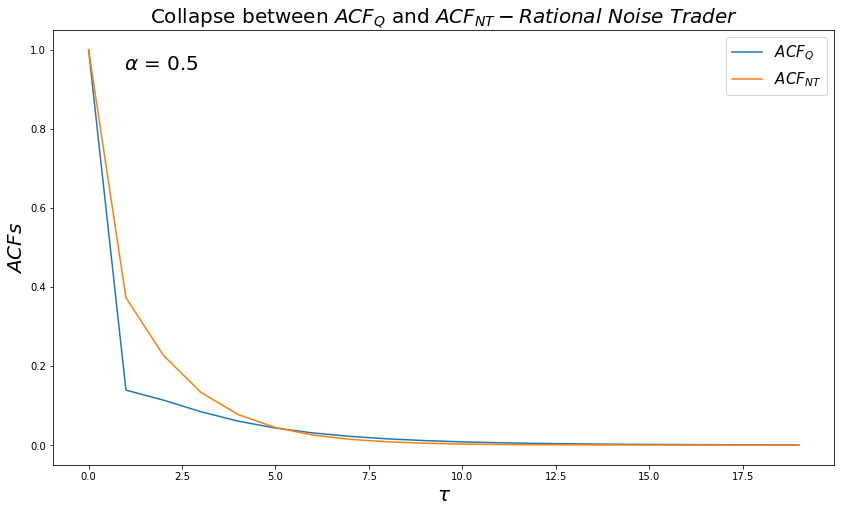

In [30]:
figure4 = plt.figure(figsize = (14,8))
plt.title(r"Collapse between $ACF_{Q}$ and $ACF_{NT} - Rational \ Noise \ Trader$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACFs$", fontsize = 20)
plt.plot(np.arange(0,20), ACFs_Q_Rational[T_it-1][0,:20]/ACFs_Q_Rational[T_it-1][0,0], label = r"$ACF_{Q}$")
plt.plot(np.arange(0,20), ACFs_NT_Rational[T_it-1][0,:20]/ACFs_NT_Rational[T_it-1][0,0] , label = r"$ACF_{NT}$")
plt.text(0.95,0.95,r"$\alpha$ = {}".format(alpha), fontsize = 20)
plt.legend(prop={'size': 15})
plt.show()

**Plotting ACF of the Informed Trader**

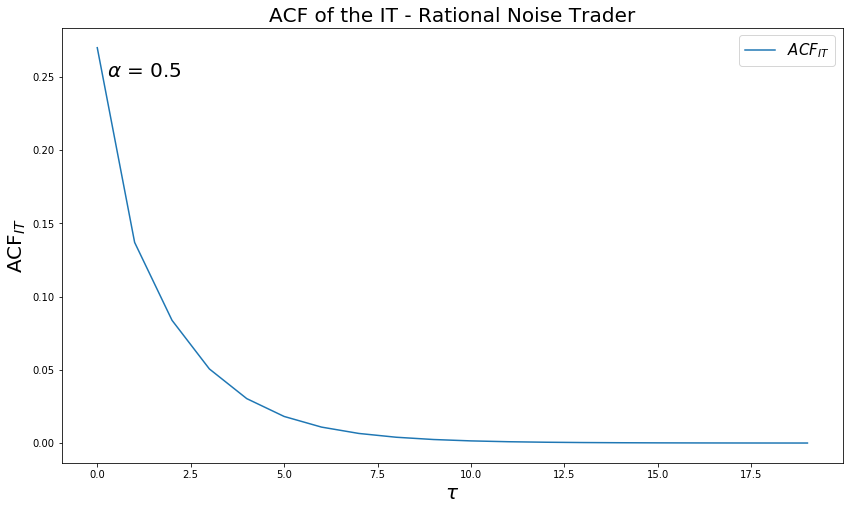

In [31]:
figure5 = plt.figure(figsize = (14,8))
plt.title("ACF of the IT - Rational Noise Trader", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$\mathsf{ACF}_{IT}$", fontsize= 20)
plt.plot(np.arange(0,20), ACFs_IT[T_it-1][0,:20], label = r"$ACF_{IT}$")
plt.text(0.25,0.25,r"$\alpha$ = {}".format(alpha), fontsize = 20)
plt.legend(prop={'size': 15})
plt.show()

## Transition Phase Analysis - Varying $\alpha$

**Propagator function for different values of $\alpha$**

In [32]:
T_phase_analysis = 200
T_it_phase_analysis = 20
tau_MU = 2
alphas_vector = np.linspace(0.0001,1.5,20)


# Target portfolio is a white noise
ACF_TGT = np.identity(T_phase_analysis)

seed_type_NT = "mark"


results_for_different_alphas = []

for i in range (0,len(alphas_vector)):
    results_for_different_alphas.append(numerical_solver_rational_noise_trader(T_phase_analysis, T_it_phase_analysis, G_0_seed, alpha_G, alphas_vector[i], C_MU_0, tau_MU, ACF_TGT, seed_type_NT, C_NT_0, tau_NT))

This is iteration: 1

This is iteration: 2

This is iteration: 3

This is iteration: 4

This is iteration: 5

This is iteration: 6

This is iteration: 7

This is iteration: 8

This is iteration: 9

This is iteration: 10

This is iteration: 11

This is iteration: 12

This is iteration: 13

This is iteration: 14

This is iteration: 15

This is iteration: 16

This is iteration: 17

This is iteration: 18

This is iteration: 19

This is iteration: 20

This is iteration: 1

This is iteration: 2

This is iteration: 3

This is iteration: 4

This is iteration: 5

This is iteration: 6

This is iteration: 7

This is iteration: 8

This is iteration: 9

This is iteration: 10

This is iteration: 11

This is iteration: 12

This is iteration: 13

This is iteration: 14

This is iteration: 15

This is iteration: 16

This is iteration: 17

This is iteration: 18

This is iteration: 19

This is iteration: 20

This is iteration: 1

This is iteration: 2

This is iteration: 3

This is iteration: 4

This is it

This is iteration: 5

This is iteration: 6

This is iteration: 7

This is iteration: 8

This is iteration: 9

This is iteration: 10

This is iteration: 11

This is iteration: 12

This is iteration: 13

This is iteration: 14

This is iteration: 15

This is iteration: 16

This is iteration: 17

This is iteration: 18

This is iteration: 19

This is iteration: 20

This is iteration: 1

This is iteration: 2

This is iteration: 3

This is iteration: 4

This is iteration: 5

This is iteration: 6

This is iteration: 7

This is iteration: 8

This is iteration: 9

This is iteration: 10

This is iteration: 11

This is iteration: 12

This is iteration: 13

This is iteration: 14

This is iteration: 15

This is iteration: 16

This is iteration: 17

This is iteration: 18

This is iteration: 19

This is iteration: 20



**Propagator functions for different values of $\alpha$**

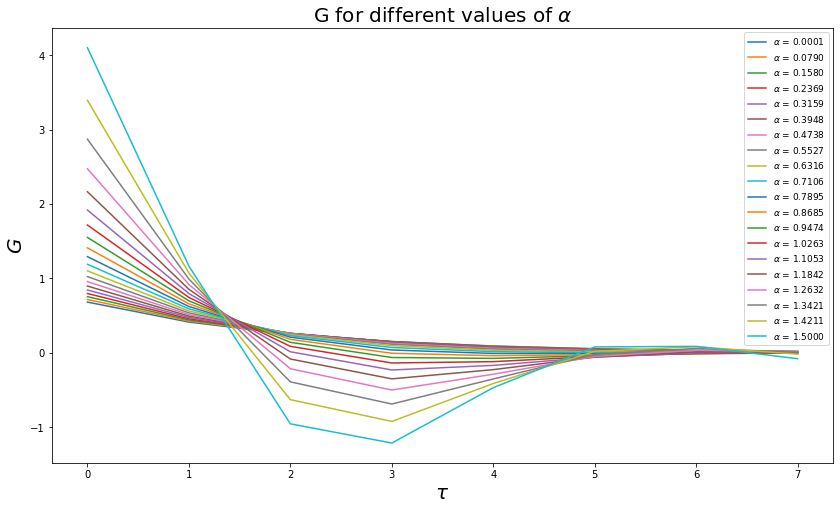

In [33]:
figure6 = plt.figure(figsize = (14,8))
plt.title(r"G for different values of $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)

for i in range (0,len(alphas_vector)):
    plt.plot(np.arange(0,8),  results_for_different_alphas[i][0][0,:8], label = r"$\alpha$ = {:.4f}".format(alphas_vector[i]))
plt.legend(loc = 1, prop={'size': 9})
plt.show()

**Auto-covariance of the Noise Trader for different values of $\alpha$**

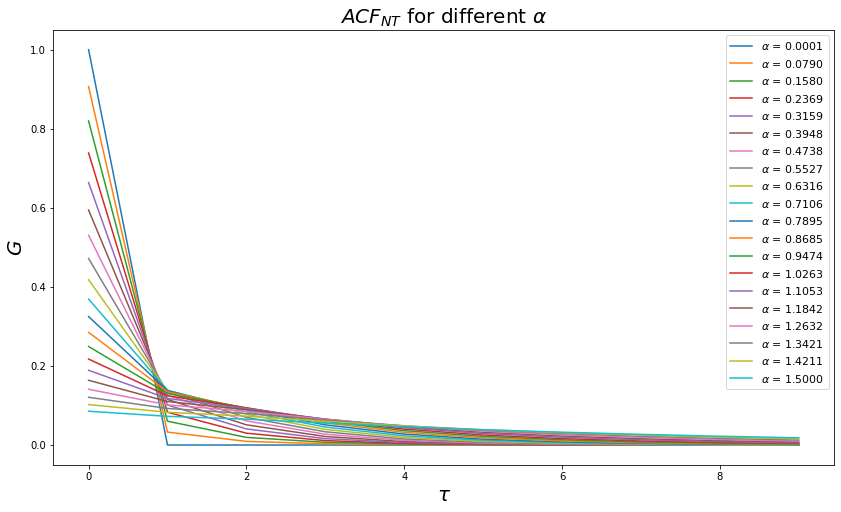

In [34]:
figure7 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{NT}$ for different $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)

for i in range (0,len(alphas_vector)):
    plt.plot(np.arange(0,10), results_for_different_alphas[i][2][T_it_phase_analysis-1][0,:10], label = r"$\alpha$ = {:.4f}".format(alphas_vector[i]))
#plt.yscale('log')
plt.legend(loc = 1, prop={'size': 11})
plt.show()

**Auto-covariance of the total excess demand for different values of $\alpha$**

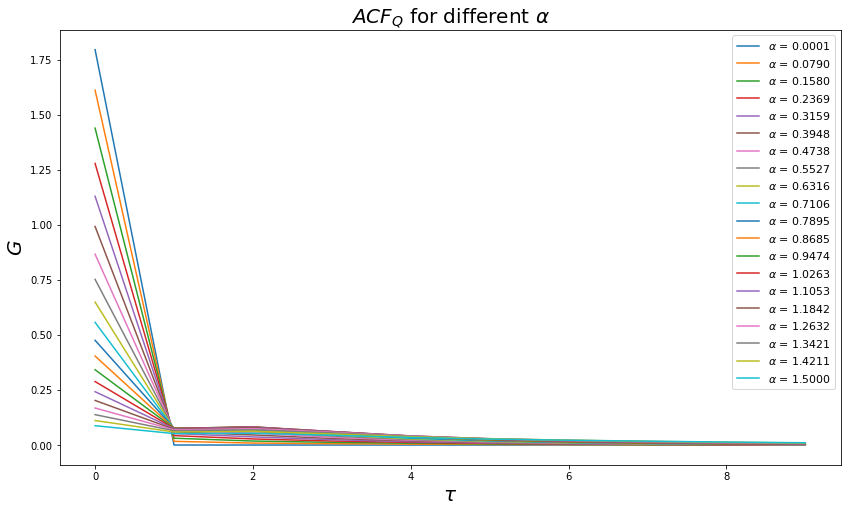

In [35]:
figure8 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{Q}$ for different $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)

for i in range (0,len(alphas_vector)):
    plt.plot(np.arange(0,10),  results_for_different_alphas[i][4][T_it_phase_analysis-1][0,:10], label = r"$\alpha$ = {:.4f}".format(alphas_vector[i]))
#plt.yscale('log')
plt.legend(loc = 1, prop={'size': 11})
plt.show()

**Superposition of the Auto-Covariance of the Noise Trader and the Total Excess Demand - Investigating the
Cammouflage of the IT**

**Biggest $\alpha$**

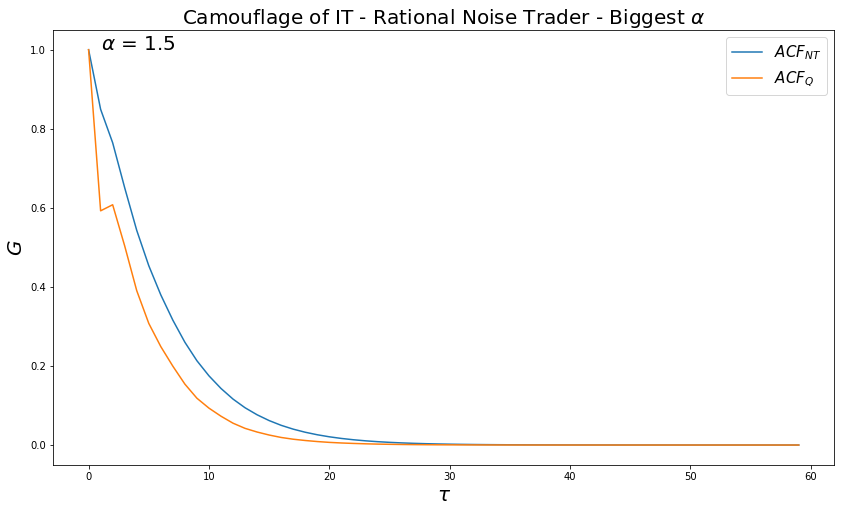

In [36]:
figure9 = plt.figure(figsize = (14,8))
plt.title(r"Camouflage of IT - Rational Noise Trader - Biggest $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)

for i in range(len(alphas_vector)-1,len(alphas_vector)):
    plt.plot(np.arange(0,60),  results_for_different_alphas[i][2][T_it_phase_analysis-1][0,:60]/results_for_different_alphas[i][2][T_it_phase_analysis-1][0,0], label = r'$ACF_{NT}$')
    plt.plot(np.arange(0,60),  results_for_different_alphas[i][4][T_it_phase_analysis-1][0,:60]/results_for_different_alphas[i][4][T_it_phase_analysis-1][0,0], label = r'$ACF_{Q}$')
plt.text(1,1,r"$\alpha$ = {}".format(alphas_vector[len(alphas_vector)-1]), fontsize = 20)
#plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

**Smallest $\alpha$**

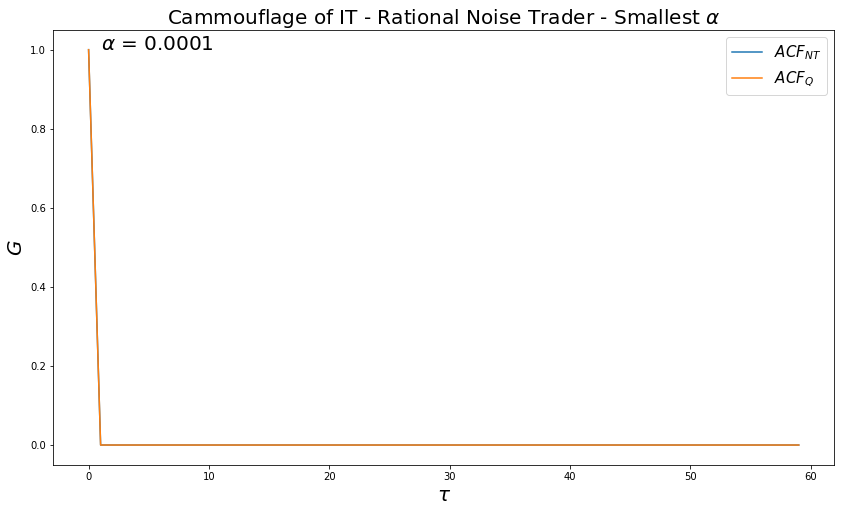

In [37]:
figure10 = plt.figure(figsize = (14,8))
plt.title(r"Cammouflage of IT - Rational Noise Trader - Smallest $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)

for i in range (0,1):
    plt.plot(np.arange(0,60),  results_for_different_alphas[i][2][T_it_phase_analysis-1][0,:60]/results_for_different_alphas[i][2][T_it_phase_analysis-1][0,0], label = r'$ACF_{NT}$')
    plt.plot(np.arange(0,60),  results_for_different_alphas[i][4][T_it_phase_analysis-1][0,:60]/results_for_different_alphas[i][4][T_it_phase_analysis-1][0,0], label = r'$ACF_{Q}$')
#plt.yscale('log')
plt.text(1,1,r"$\alpha$ = {}".format(alphas_vector[0]), fontsize = 20)
plt.legend(prop={'size': 15})
plt.show()

## Variance Analysis

**Covariance of the Total Excess Demand for different values of $\alpha$**

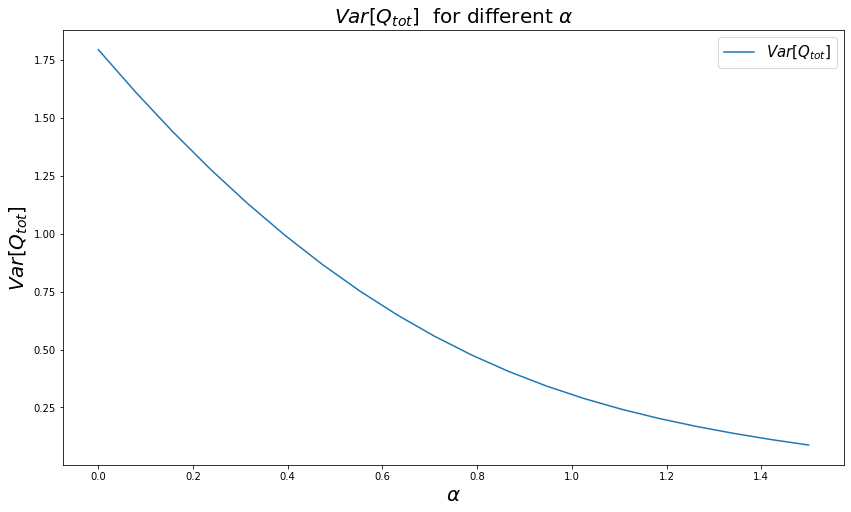

In [38]:
figure11 = plt.figure(figsize = (14,8))
plt.title(r"$Var[Q_{tot}]$  for different $\alpha$", fontsize = 20)
plt.xlabel(r"$\alpha$", fontsize = 20)
plt.ylabel(r"$Var[Q_{tot}]$", fontsize = 20)


covariances_Q = []

for i in range(0, len(alphas_vector)):
    covariances_Q.append(results_for_different_alphas[i][4][T_it_phase_analysis-1][0,0])
    

plt.plot(alphas_vector, covariances_Q, label = r"$Var[Q_{tot}]$")
#plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

**Covariance of the Noise Trader's Demand for different values of $\alpha$**

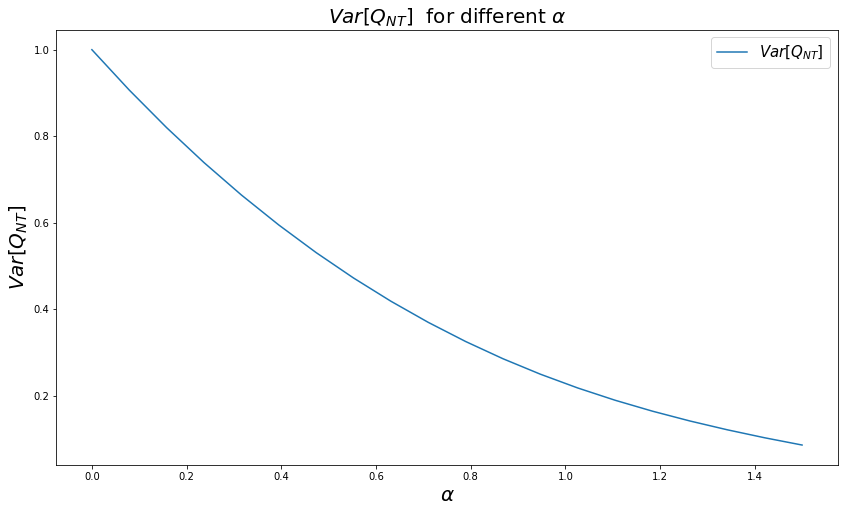

In [39]:
figure12 = plt.figure(figsize = (14,8))
plt.title(r"$Var[Q_{NT}]$  for different $\alpha$", fontsize = 20)
plt.xlabel(r"$\alpha$", fontsize = 20)
plt.ylabel(r"$Var[Q_{NT}]$", fontsize = 20)


covariances_Q_NT = []

for i in range(0, len(alphas_vector)):
    covariances_Q_NT.append(results_for_different_alphas[i][2][T_it_phase_analysis-1][0,0])
    

plt.plot(alphas_vector, covariances_Q_NT, label = r"$Var[Q_{NT}]$")
#plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

## Studying Price Efficiency

**Price efficiency for the biggest $\alpha$**

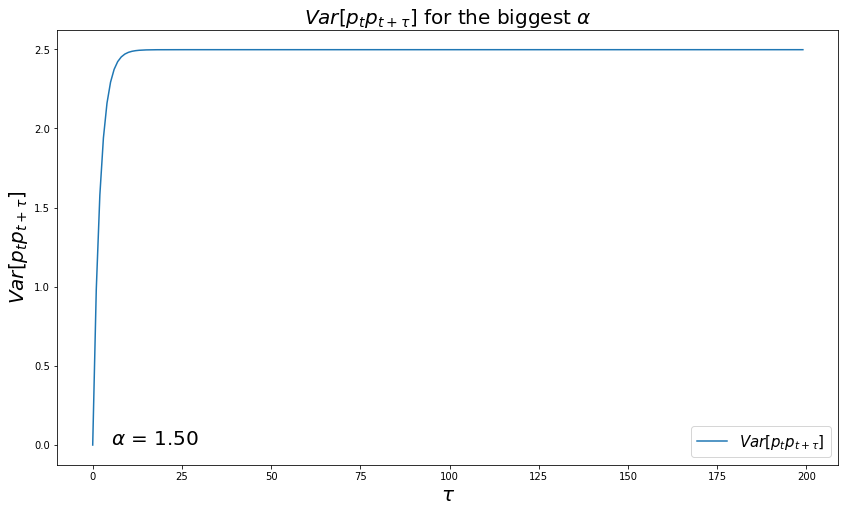

In [40]:
figure13 = plt.figure(figsize = (14,8))
plt.title(r"$Var[p_{t}p_{t + \tau}]$ for the biggest $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$Var[p_{t}p_{t + \tau}]$", fontsize = 20)

final_result = results_for_different_alphas[len(alphas_vector) - 1]

G_final = final_result[0]

ACF_Q_final = final_result[4][T_it_phase_analysis-1]

ACF_P_final = return_ACF_P(ACF_Q_final, G_final)


plt.plot(np.arange(0,T_phase_analysis), 2*ACF_P_final[0,0]*(1 - ACF_P_final[0,:]/ACF_P_final[0,0]), label = r"$Var[p_{t}p_{t + \tau}]$")
plt.text(5,0,r"$\alpha$ = {:.2f}".format(alphas_vector[len(alphas_vector)-1]), fontsize = 20)
#plt.yscale('log')
plt.legend(prop={'size': 15})
plt.show()

**Price efficiency for different values of $\alpha$**

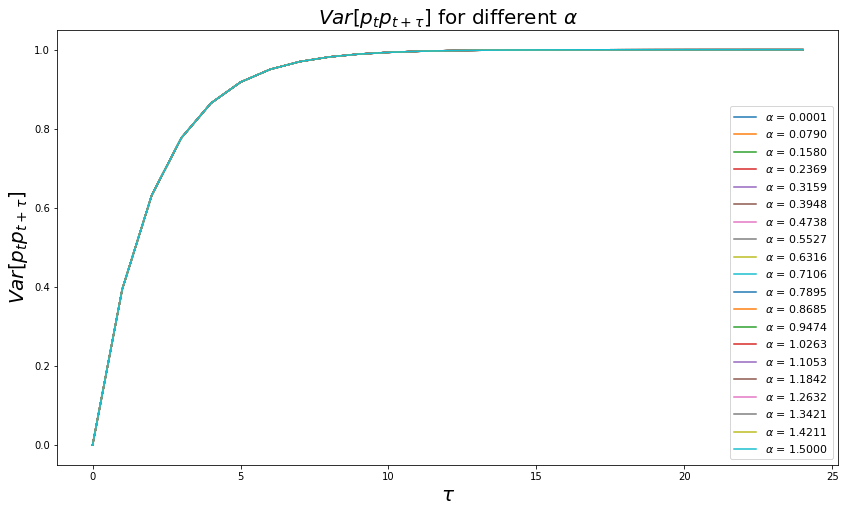

In [41]:
figure14 = plt.figure(figsize = (14,8))
plt.title(r"$Var[p_{t}p_{t + \tau}]$ for different $\alpha$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$Var[p_{t}p_{t + \tau}]$", fontsize = 20)


final_results = []


for i in range(0,len(alphas_vector)):
    final_results.append(results_for_different_alphas[i])
 

ACFs_P = []

for i in range(0,len(alphas_vector)):
    G_final = final_results[i][0]
    ACF_Q_final = final_results[i][4][T_it_phase_analysis-1]
    ACFs_P.append(return_ACF_P(ACF_Q_final, G_final))
    
    

for i in range(0,len(alphas_vector)):
    plt.plot(np.arange(0,25), (1 - ACFs_P[i][0,:25]/ACFs_P[i][0,0]), label = r"$\alpha$ = {:.4f}".format(alphas_vector[i]))
#plt.plot(np.arange(0,25),2*(1 - ACF_MU_Rational[0,:25]/C_MU_0), label = r"$ACF_{MU}/C_{\mu}^{0}$")

#plt.yscale('log')
plt.legend(loc = 4, prop={'size': 11})
plt.show()

## Studying the behavior of $\tau_{NT}(\alpha)$  

In [284]:
ACFs_NT_log = []
ACFs_NT = []
ACFs_Q = []

data_points = 20

for i in range(0, len(alphas_vector)):
    ACFs_NT_log.append(results_for_different_alphas[i][2][T_it_phase_analysis-1][0,:data_points])
    ACFs_Q.append(results_for_different_alphas[i][4][T_it_phase_analysis-1][0,:data_points])

 
ACFs_NT =  ACFs_NT_log.copy()
    
x_points = np.arange(0,data_points)
x_points_aux = x_points.copy()

curve_parameters = []

for i in range(0, len(alphas_vector)):
    ACFs_NT_log[i] = np.log(ACFs_NT_log[i])
    curve_parameters.append(np.polyfit(x_points[1:], ACFs_NT_log[i][1:], 1))

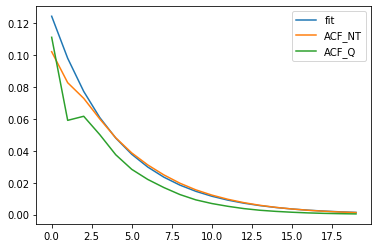

In [286]:
plt.plot(x_points[:],  np.exp(curve_parameters[18][1])*np.exp(curve_parameters[18][0]*x_points[:]), label = "fit")
plt.plot(x_points[:], ACFs_NT[18][:], label = "ACF_NT")
plt.plot(x_points[:], ACFs_Q[18][:], label = "ACF_Q")
plt.legend()

## Analysis of Results - Irrational Noise Trader

In [596]:
T = 200
T_it = 20
G_0_seed = 1
alpha_G = 0.5 
tau_MU = 2
tau_NT = 1
C_MU_0 = 1
C_NT_0 = 1

#numerical_solver_irrational_noise_trader(T, T_it, G_0_seed, alpha_G, C_MU_0, C_NT_0, tau_MU, tau_NT)
G_Irrational, G_s_Irrational, ACF_Q_Irrational, ACF_NT_Irrational, ACF_MU_Irrational, ACF_P_Irrational, ACF_P_F_Irrational, ACF_IT_Irrational = numerical_solver_irrational_noise_trader(T, T_it, G_0_seed, alpha_G, C_MU_0, C_NT_0, tau_MU, tau_NT)



This is iteration: 1

This is iteration: 2

This is iteration: 3

This is iteration: 4

This is iteration: 5

This is iteration: 6

This is iteration: 7

This is iteration: 8

This is iteration: 9

This is iteration: 10

This is iteration: 11

This is iteration: 12

This is iteration: 13

This is iteration: 14

This is iteration: 15

This is iteration: 16

This is iteration: 17

This is iteration: 18

This is iteration: 19

This is iteration: 20



## Last propagator found - Irrational Noise Trader

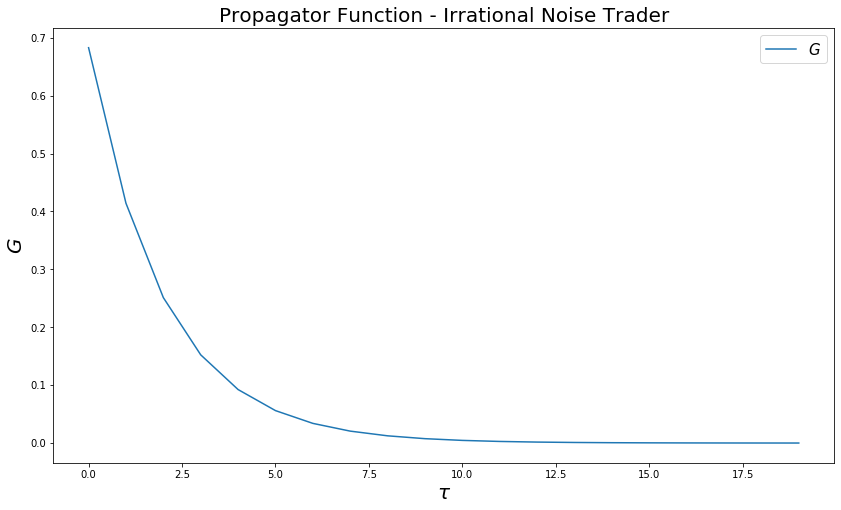

In [597]:
figure15 = plt.figure(figsize = (14,8))
plt.title("Propagator Function - Irrational Noise Trader", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)
plt.plot(np.arange(0,20),G_Irrational[0,:20], label = r"$G$")
plt.legend(prop={'size': 15})
plt.show()

##  $G/G_{0}$ and $C_{\mu}/C_{\mu}^{0}$

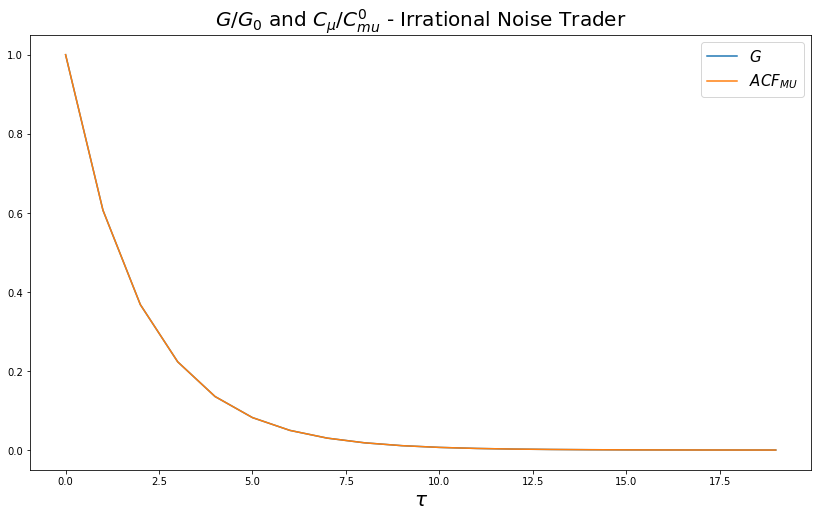

In [598]:
figure16 = plt.figure(figsize = (14,8))
plt.title(r"$G/G_{0}$ and $C_{\mu}/C_{mu}^{0}$ - Irrational Noise Trader", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.plot(np.arange(0,20), G_Irrational[0,:20]/G_Irrational[0,0], label = r"$G$")
plt.plot(np.arange(0,20), ACF_MU_Irrational[0,:20]/C_MU_0, label = r"$ACF_{MU}$")
plt.legend(prop={'size': 15})
plt.show()

## Collapse between $ACF_{Q}$ and $ACF_{NT}$ - Irrational Noise Trader

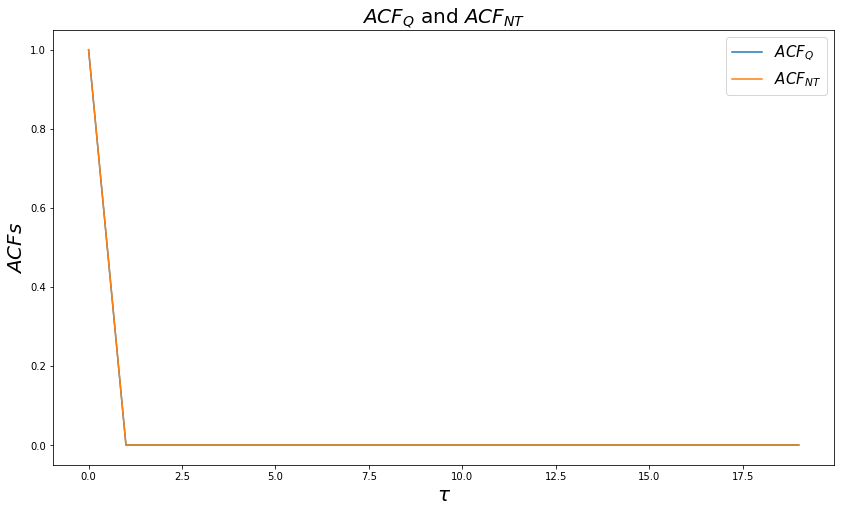

In [599]:
figure17 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{Q}$ and $ACF_{NT}$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACFs$", fontsize = 20)
plt.plot(np.arange(0,20),ACF_Q_Irrational[0,:20]/ACF_Q_Irrational[0,0], label = r"$ACF_{Q}$")
plt.plot(np.arange(0,20), ACF_NT_Irrational[0,:20]/ACF_NT_Irrational[0,0], label = r"$ACF_{NT}$")
plt.legend(prop={'size': 15})
plt.show()

## $ACF_{IT}$

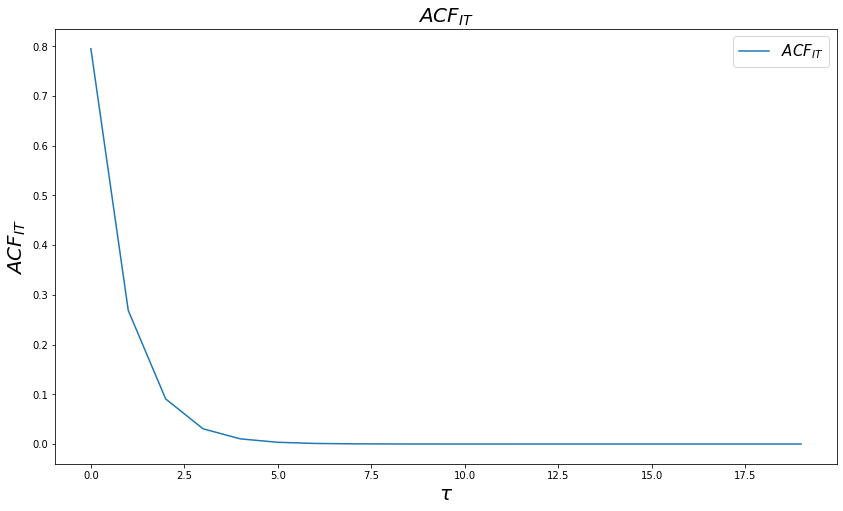

In [600]:
figure18 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{IT}$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACF_{IT}$", fontsize = 20)
plt.plot(np.arange(0,20), ACF_IT_Irrational[0,:20], label = r"$ACF_{IT}$")
plt.legend(prop={'size': 15})
plt.show()

## $ACF_{P}$

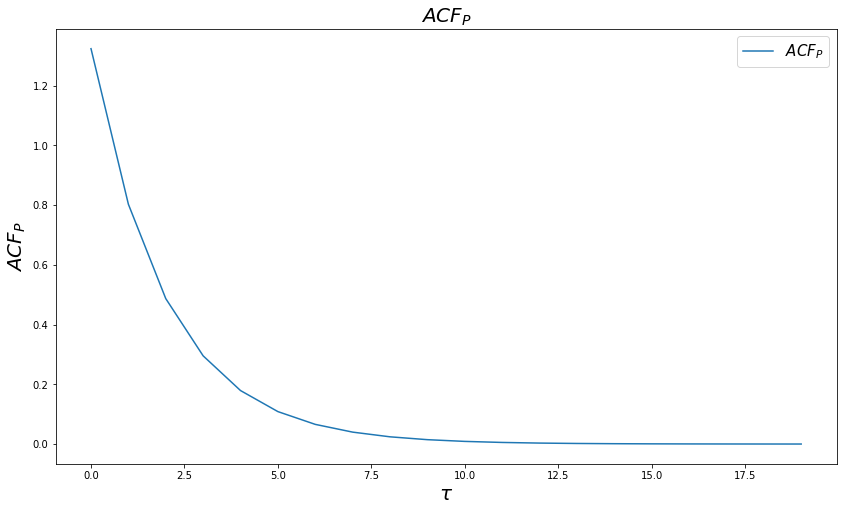

In [601]:
figure19 = plt.figure(figsize = (14,8))
plt.title(r"$ACF_{P}$", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$ACF_{P}$", fontsize = 20)
plt.plot(np.arange(0,20), ACF_P_Irrational[0,:20], label = r"$ACF_{P}$")
plt.legend(prop={'size': 15})
plt.show()

## Comparison between Irrational and Rational Noise Trader Cases

**Propagator Comparison**

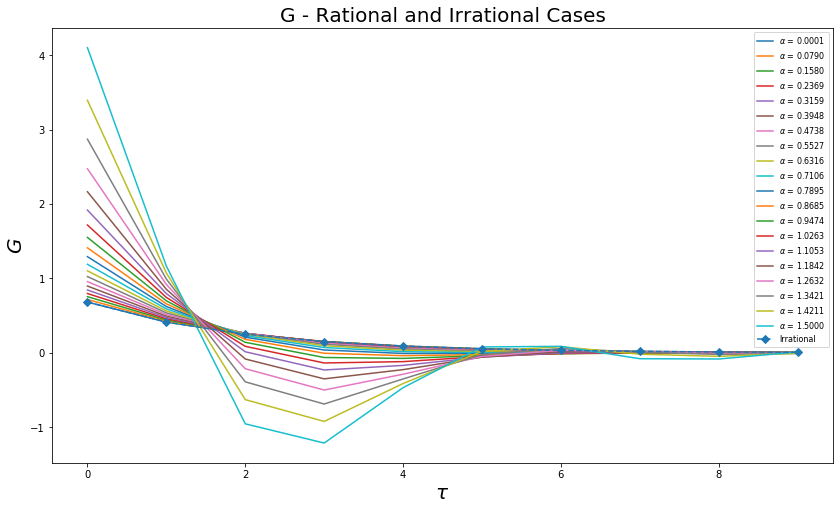

In [614]:
figure20 = plt.figure(figsize = (14,8))
plt.title(r"G - Rational and Irrational Cases", fontsize = 20)
plt.xlabel(r"$\tau$", fontsize = 20)
plt.ylabel(r"$G$", fontsize = 20)

for i in range (0,len(alphas_vector)):
    plt.plot(np.arange(0,10),  results_for_different_alphas[i][0][0,:10], label = r"$\alpha$ = {:.4f}".format(alphas_vector[i]))
plt.plot(np.arange(10), G_Irrational[0,:10],linestyle='dashed',  label = "Irrational", marker = 'D')    
plt.legend(loc = 1, prop={'size': 8})
plt.show()